## Имена, которые давали детям в США за период с 1880 по 2010 год

Управление социального обеспечения США выложило в сеть данные о частоте встречаемости детских имен за период с 1880 года по настоящее время. Хэдли Уикхэм (Hadley Wickham), автор нескольких популярных пакетов для R, часто
использует этот пример для иллюстрации манипуляций с данными в R.

С этим набором можно проделать много интересного.

+ Наглядно представить долю младенцев, получавших данное имя ( совпадающее с вашим или какое-нибудь другое) за весь период времени.
+ Определить относительный ранг имени.
+ Найти самые популярные в каждом году имена или имена, для которых фиксировалось наибольшее увеличение или уменьшение частоты.
+ Проанализировать тенденции выбора имен: количество гласных и согласных, длину, общее разнообразие, изменение в написании, первые и последние буквы.
+ Проанализировать внешние источники тенденций: библейские имена, имена знаменитостей, демографические изменения.

С помощью уже рассмотренных инструментов большая часть этих задач решается очень просто.

На момент написания этой книги Управление социального обеспечения США
представило данные в виде набора файлов, по одному на каждый год, в которых
указано общее число родившихся младенцев для каждой пары пол/имя. Архив
этих файлов находится по адресу

**http://www.ssa.gov/oact/babynames/limits.html**

Поскольку поля разделены запятыми, файл можно загрузить в объект DataFrame методом pandas.read_csv:

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Путь в inux
path = './pydata-book-2nd-edition/datasets/babynames/'

In [6]:
name1880 = pd.read_csv(path + 'yob1880.txt', names=['name', 'sex', 'births'])

In [7]:
name1880.head()

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


В эти файлы включены только имена, которыми были названы не менее 5 младенцев в году, поэтому для простоты сумму значений в столбце sex можно считать общим числом родившихся в данном году младенцев:

In [8]:
name1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

Поскольку в каждом файле находятся данные только за один год, то первое, что нужно сделать, - собрать все данные в единый объект DataFrame и добавить поле year. Это легко сделать методом **pandas.concat**:

In [9]:
years = range(1880, 2011)

In [10]:
pieces = []

In [11]:
columns = ['name', 'sex', 'births']

In [12]:
for year in years:
    file_path = path + 'yob%d.txt' % year
    frame = pd.read_csv(file_path, names=columns)
    frame['year'] = year
    pieces.append(frame)

Собираем все данные в один объект DataFrame

In [13]:
names = pd.concat(pieces, ignore_index=True)

In [14]:
names.head()

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


Стоит обратить внимание на два момента. Во-первых, concat по умолчанию объединяет объекты DataFramc построчно. Во-вторых, следует задать параметр ignore_index = True, потому что нет необходимости сохранять исходные номера строк, прочитанных методом read_csv. Таким образом,получается очень большой DataFrame, содержащий данные обо всех именах.

Можем приступить к агрегированию на уровне года и пола, используя метод groupby или pivot_table

In [15]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

Далее вставим столбец prop, содержащий долю младенцев, получивших данное имя, относительно общего числа родившихся. Значение prop, равное 0,02, означает, что данное имя получили 2 из 100 млменцев. Затем сгруппируем данные по
году и полу и добавим в каждую группу новый столбец:

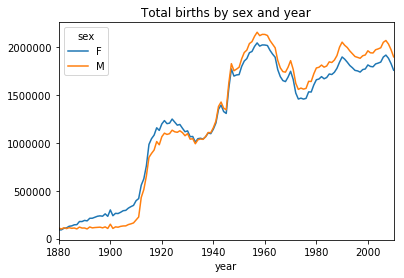

In [16]:
total_births.plot(title = 'Total births bу sex and year')
plt.show()

In [17]:
def add_prop(group):
    #При целочисленном делении производится округление с недостатком
    births = group.births.astype(float)
    group['prop'] = births / births.sum()
    return group

In [18]:
names = names.groupby(['year', 'sex']).apply(add_prop)

При выполнении такой операции группировки часто бывает полезно произвести проверку разумности результата, например, удостовериться, что сумма значений в столбце prop по всем группам равна 1. Поскольку это данные с плавающей
точкой, воспользуемся методом np.allclose, который проверяет, что сумма по группам достаточно близка к 1 (хотя может и не быть равна в точности).

In [19]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

Дабы упростить последующий анализ, извлечем подмножества данных:
первые 1000 имен для каждой комбинации пола и года. Это еще одна групповая
операция

In [20]:
def get_top1000(group):
    return group.sort_index(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

/home/andrey/programming/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


In [21]:
# Результирующий набор стал меньше и удобнее
top1000

name sex  births  year      prop
year sex                                               
1880 F   0             Mary   F    7065  1880  0.077643
         1             Anna   F    2604  1880  0.028618
         2             Emma   F    2003  1880  0.022013
         3        Elizabeth   F    1939  1880  0.021309
         4           Minnie   F    1746  1880  0.019188
         5         Margaret   F    1578  1880  0.017342
         6              Ida   F    1472  1880  0.016177
         7            Alice   F    1414  1880  0.015540
         8           Bertha   F    1320  1880  0.014507
         9            Sarah   F    1288  1880  0.014155
         10           Annie   F    1258  1880  0.013825
         11           Clara   F    1226  1880  0.013474
         12            Ella   F    1156  1880  0.012704
         13        Florence   F    1063  1880  0.011682
         14            Cora   F    1045  1880  0.011484
         15          Martha   F    1040  1880  0.011429
         16           Laura   F    1012  1880  0.011122
         17          Nellie   F     995  1880  0.010935
         18           Grace   F     982  1880  0.010792
         19          Carrie   F     949  1880  0.010429
         20           Maude   F     858  1880  0.009429
         21           Mabel   F     808  1880  0.008880
         22          Bessie   F     794  1880  0.008726
         23          Jennie   F     793  1880  0.008715
         24        Gertrude   F     787  1880  0.008649
         25           Julia   F     783  1880  0.008605
         26          Hattie   F     769  1880  0.008451
         27           Edith   F     768  1880  0.008440
         28          Mattie   F     704  1880  0.007737
         29            Rose   F     700  1880  0.007693
...                     ...  ..     ...   ...       ...
2010 M   1677617       Yair   M     201  2010  0.000106
         1677616      Talan   M     201  2010  0.000106
         1677614      Keyon   M     201  2010  0.000106
         1677613       Kael   M     201  2010  0.000106
         1677618   Demarion   M     200  2010  0.000105
         1677619     Gibson   M     200  2010  0.000105
         1677620     Reagan   M     200  2010  0.000105
         1677621  Cristofer   M     199  2010  0.000105
         1677622     Daylen   M     199  2010  0.000105
         1677623     Jordon   M     199  2010  0.000105
         1677624    Dashawn   M     198  2010  0.000104
         1677625      Masen   M     198  2010  0.000104
         1677629      Rowen   M     197  2010  0.000104
         1677631     Yousef   M     197  2010  0.000104
         1677630   Thaddeus   M     197  2010  0.000104
         1677628      Kadin   M     197  2010  0.000104
         1677627     Dillan   M     197  2010  0.000104
         1677626   Clarence   M     197  2010  0.000104
         1677634      Slade   M     196  2010  0.000103
         1677632    Clinton   M     196  2010  0.000103
         1677633    Sheldon   M     196  2010  0.000103
         1677636    Keshawn   M     195  2010  0.000103
         1677637   Menachem   M     195  2010  0.000103
         1677635     Joziah   M     195  2010  0.000103
         1677638     Bailey   M     194  2010  0.000102
         1677639     Camilo   M     194  2010  0.000102
         1677640     Destin   M     194  2010  0.000102
         1677641     Jaquan   M     194  2010  0.000102
         1677642     Jaydan   M     194  2010  0.000102
         1677645     Maxton   M     193  2010  0.000102

[261877 rows x 5 columns]

### Анализ тенденций в выборе имен

Имея полный набор данных и первые 1000 записей, можно приступить к анализу различных интересных тенденций. Для начала решим простую задачу:

разобьем набор Тор1000на части, относящиеся к мальчикам и девочкам.

In [22]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

Можно нанести на график простые временные ряды, например количество Джанов и Мэри в каждом году, но для этого потребуется предварительное переформатирование. Сформируем сводную таблицу, в которой представлено общее
число родившихся по годам и по именам:

In [23]:
total_births = top1000.pivot_table( 'births', index = 'year', columns = 'name', aggfunc = sum)

In [24]:
total_births.head()

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,...,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,...,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,...,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,...,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,...,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,...,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN


Теперь можно нанести на график несколько имен, воспользовавшись методом plot объекта DataFraшe:

In [25]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

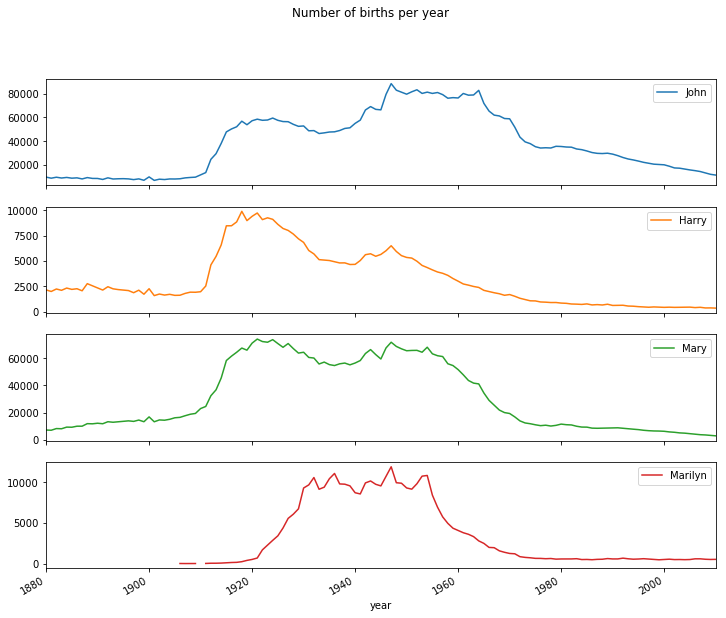

In [26]:
subset.plot(subplots=True, figsize = (12, 10), grid = False, title= "Number of births per year")
plt.show()

### Измерение роста разнообразия имен

Убывание кривых на рисунках выше можно объяснить тем, что меньше родителей стали выбирать такие распространенные имена. Эту гипотезу можно проверить и подтвердить имеющимися данными. Один из возможных показателей - доля родившихся в наборе 1000 самых популярных имен, агрегированных по году и полу:

In [27]:
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)

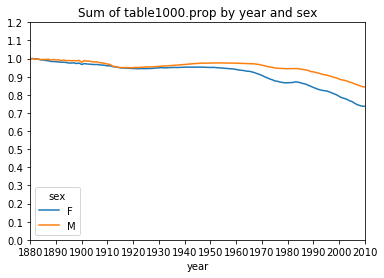

In [28]:
table.plot(title='Sum of table1000.prop by year and sex',yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))
plt.show()

Действительно, похоже, что разнообразие имен растет (доля в первой тысяче падает). Другой интересный показатель - количество различных имен среди первых 50 % родившихся, упорядоченное по популярности в порядке убывания. Вычислить его несколько сложнее. Рассмотрим толькоимена мальчиков, родившихся в 2010 году:

In [29]:
df = boys[boys.year == 2010]

In [30]:
df.head()

name sex  births  year      prop
year sex                                             
2010 M   1676644    Jacob   M   21875  2010  0.011523
         1676645    Ethan   M   17866  2010  0.009411
         1676646  Michael   M   17133  2010  0.009025
         1676647   Jayden   M   17030  2010  0.008971
         1676648  William   M   16870  2010  0.008887

После сортировки *prop* в порядке убывания мы хотим узнать, сколько популярных имен нужно взять, чтобы достичь 50 %. Можно написать для этого цикл for, но NumPy предлагает более хитроумный векторный подход. Если вычислить накопительные суммы cumsum массива prop, а затем вызвать метод searchsorted, то будет возвращена позиция в массиве накопительных сумм, в которую нужно было
бы вставить 0.5, чтобы не нарушить порядок сортировки:

In [31]:
prop_cumsum = df.sort_index(by='prop', ascending=False).prop.cumsum()

/home/andrey/programming/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


In [32]:
prop_cumsum[:10]

year  sex         
2010  M    1676644    0.011523
           1676645    0.020934
           1676646    0.029959
           1676647    0.038930
           1676648    0.047817
           1676649    0.056579
           1676650    0.065155
           1676651    0.073414
           1676652    0.081528
           1676653    0.089621
Name: prop, dtype: float64

In [33]:
prop_cumsum.searchsorted(0.5)

array([116])

Поскольку индексация массивов начинается с нуля, то нужно прибавить к результату 1 - получится 117. Заметим, что в 1900 году этот показатель был гораздо меньше:

In [34]:
df = boys[boys.year == 1900]

In [35]:
in1900 = df.sort_index(by='prop', ascending=False).prop.cumsum()

/home/andrey/programming/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


In [36]:
in1900.searchsorted(0.5) + 1

array([25])

Теперь нетрудно применить эту операцию к каждой комбинации года и пола;
произведем группировку по этим полям с помощью метода groupby, а затем с помощью метода apply применим функцию, возвращающую нужный показатель для каждой группы:

In [37]:
def get_quantile_count(group, q=0.5):
    group = group.sort_index(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1
diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

/home/andrey/programming/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


В получившемся объекте DataFrame с именем diversity хранится два временных ряда, по одному для каждого поля, индексированные по году. Его можно исследовать в IPython и, как и раньше, нанести на график.

In [54]:
diversity.head()

sex,F,M
year,,
1880,[38],[14]
1881,[38],[14]
1882,[38],[15]
1883,[39],[15]
1884,[39],[16]


In [55]:
df=diversity.astype(float)

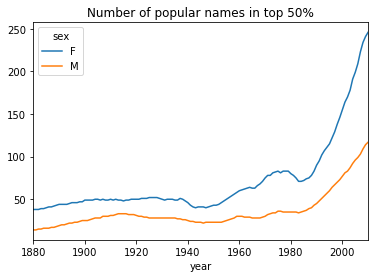

In [56]:
df.plot(title = "Number of popular names in top 50%")
plt.show()

Заметно, что девочкам всегда давали более разнообразные имена, чем мальчикам,и со временем эта тенденция проявляется все ярче.

### Революция «последней буквы»

В 2007 году исследователышца детских имен Лаура Уоттенберг (Laura Wattenberg) отметила на своем сайте (http://www.babynamewizard.com), что распределение
имен мальчиков по последней букве за последние 100 лет существенно изменилось. Чтобы убедиться в этом, сначала агрегируем данные полного набора обо всех родившихся по году, полу и последней букве:

In [68]:
# извлекаем последнюю букву имени в столбце name
get_last_letter = lambda х: х[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'
table = names.pivot_table('births', index=last_letters, columns = ['sex', 'year'], aggfunc=sum)

In [69]:
names.head()

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


In [70]:
table.head()

sex                F                                                        \
year            1880     1881     1882     1883     1884     1885     1886   
last_letter                                                                  
a            31446.0  31581.0  36536.0  38330.0  43680.0  45408.0  49100.0   
b                NaN      NaN      NaN      NaN      NaN      NaN      NaN   
c                NaN      NaN      5.0      5.0      NaN      NaN      NaN   
d              609.0    607.0    734.0    810.0    916.0    862.0   1007.0   
e            33378.0  34080.0  40399.0  41914.0  48089.0  49616.0  53884.0   

sex                                       ...            M            \
year            1887     1888     1889    ...         2001      2002   
last_letter                               ...                          
a            48942.0  59442.0  58631.0    ...      39124.0   38815.0   
b                NaN      NaN      NaN    ...      50950.0   49284.0   
c                NaN      NaN      NaN    ...      27113.0   27238.0   
d             1027.0   1298.0   1374.0    ...      60838.0   55829.0   
e            54353.0  66750.0  66663.0    ...     145395.0  144651.0   

sex                                                                      \
year             2003      2004      2005      2006      2007      2008   
last_letter                                                               
a             37825.0   38650.0   36838.0   36156.0   34654.0   32901.0   
b             48065.0   45914.0   43144.0   42600.0   42123.0   39945.0   
c             27697.0   26778.0   26078.0   26635.0   26864.0   25318.0   
d             53391.0   51754.0   50670.0   51410.0   50595.0   47910.0   
e            144769.0  142098.0  141123.0  142999.0  143698.0  140966.0   

sex                              
year             2009      2010  
last_letter                      
a             31430.0   28438.0  
b             38862.0   38859.0  
c             24048.0   23125.0  
d             46172.0   44398.0  
e            135496.0  129012.0  

[5 rows x 262 columns]

Bыберем из всего периода три репрезентативных года и напечатаем первые несколько строк

In [71]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')

In [72]:
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

Пронормируем эту таблицу на общее число родившихся, чтобы вычислить новую таблицу, содержащую долю от общего числа родившихся для каждого пола и каждой последней буквы:

In [73]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [77]:
letter_prop = subtable / subtable.sum().astype(float)

Зная доли букв, можно нарисовать столбчатые диаграммы для каждого пола, разбив их по годам.

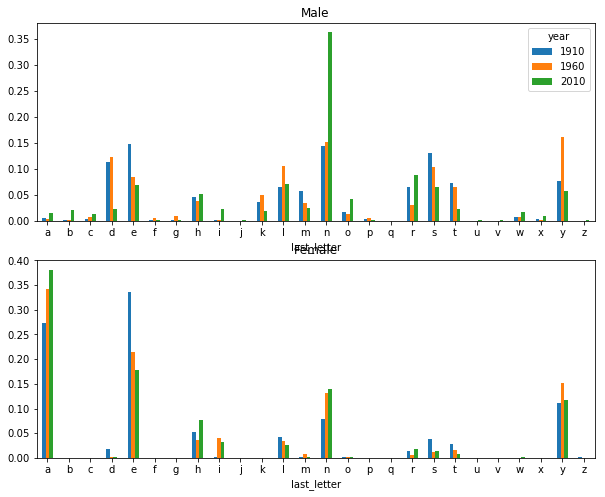

In [81]:
fig, axes = plt.subplots(2, 1, figsize = (10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title = 'Male')
letter_prop['F'].plot(kind='bar', rot=0, ax = axes[1], title = 'Female', legend=False)
plt.show()

Как видим, с 1960-х годов доля имен мальчиков, заканчивающихся буквой "n",
значительно возросла. Вернемся к созданной ранее полной таблице, пронормирую ее по году и полу, выберем некое подмножество букв для имен мальчиков и транспонируем, чтобы превратить каждый столбец во временной ряд:

In [83]:
letter_prop = table / table.sum().astype(float)

In [91]:
dny_ts = letter_prop.ix[['d', 'n', 'y'], 'M'].T

In [92]:
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


Имея этот объект DataFrame, содержащие временные ряды, можно методом plot построить график изменения тенденций в зависимости от времени:

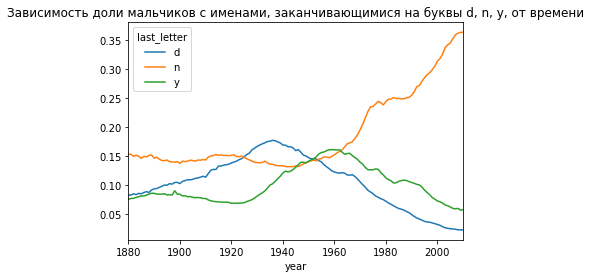

In [93]:
dny_ts.plot()
plt.title('Зависимость доли мальчиков с именами, заканчивающимися на буквы d, n, у, от времени')
plt.show()

### Мужские имена, ставшие женскими, и наоборот

Еще одно интересное упражнение - изучить имена, которые раньше часто давали мальчикам, а затем "сменили пол". Возьмем, к примеру, имя Leslcy или Leslie. По набору top1000 вычислим список имен, начинающихся с · lesl ·:

In [94]:
all_names = top1000.name.unique()

In [96]:
mask = np.array(['lesl' in x.lower() for x in all_names])

In [97]:
lesley_like = all_names[mask]

In [98]:
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

Далее можно оставить только эти имена и просуммировать количество родившихся, сгруппировав по имени, чтобы найти относительные частоты

In [99]:
filtered = top1000[top1000.name.isin(lesley_like)]

In [100]:
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

Затем агрегируем по полу и году и нормируем в пределах каждого года:

In [106]:
table = filtered.pivot_table('births', index = 'year', columns = 'sex', aggfunc = 'sum')

In [107]:
table = table.div(table.sum(1), axis = 0)

In [108]:
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


Наконец, нетрудно построить график распределения по полу в зависимости от
времени

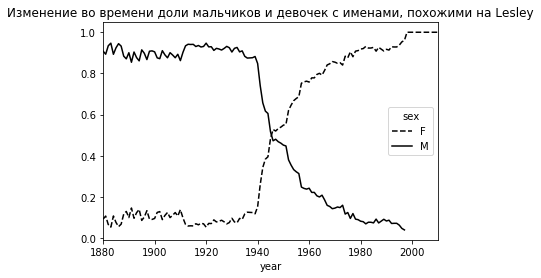

In [110]:
table.plot(style = {'M':'k-', 'F':'k--'})
plt.title('Изменение во времени доли мальчиков и девочек с именами, похожими на Lesley')
plt.show()